## Movie Review Sentiment Analysis 

Author: Zixi Liu

#### Research Question

In this case study, we are provided with a dataset consisting 35,000 IMDB movie reviews, where each review is labeled as positive or negative. The goal is to build a binary classification model to predict the sentiment of a movie review based one new test data.

#### Methods

Since the task is a binary classification problem, the procedures to approach the problem are as follows:

- Preprocessed the review texts by cleaning, normalizing and tokenizing (segmenting) texts to prepare for the text corpus;
- Trained a standlone vocabulary list (less than 1000 rows) from word embedding base on the corpus using word2vec;
- Built a sentiment analysis model based on Long short-term memory Netwok (LSTM), which is a Recurrent Neural Network (RNN) based model, in order to try to predict if an review is positive (1) or negative (0); Word embedding and sentiment are then fed into the LSTM model and train over cycles.
- The classification performance was evaluated using the area under the ROC curve (AUC). Confusion matrix from the best performing model and performance improvement over training cycles are demonstrated.

#### Data Prepararion

In [2]:
# Import libraries
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set(style='whitegrid')
import re
import logging
FORMAT = '%(asctime)s %(clientip)-15s %(user)-8s %(message)s'
logging.basicConfig(format=FORMAT)
logger = logging.getLogger('tcpserver')

In [26]:
# Read and parse data
df_train = pd.read_csv('C:/Users/zliu3/ds-take-home-challenge/movie_review_data.tsv', sep = '\t')
df_test = pd.read_csv('C:/Users/zliu3/ds-take-home-challenge/score_data.tsv', sep = '\t')

df_train.head()

,id,sentiment,score,review
0,1,1,10,Naturally in a film who's main themes are of m...
1,3,0,4,"All in all, this is a movie for kids. We saw i..."
2,4,0,2,Afraid of the Dark left me with the impression...
3,7,0,1,This has to be one of the biggest misfires eve...
4,8,0,2,"This is one of those movies I watched, and won..."


#### Check class balance

Let's check class balance because if the training datasets are imbalanced, the trained classifier will tend to predict the test samples into a majority, making the recall of minority very low. However, we have a balanced training dataset (50% negative sentiments vs 50% positive sentiments).

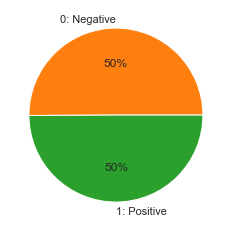

In [207]:
#define data
data = [df_train[df_train.sentiment == 0].sentiment.count()/df_train.sentiment.count(),
        df_train[df_train.sentiment == 1].sentiment.count()/df_train.sentiment.count()]
labels = ['0: Negative', '1: Positive']

#define Seaborn color palette to use
colors = sns.color_palette("tab10")[1:3]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

#### 1. Preprocess Texts

Let's first clean up text reviews to normalize texts and remove noise as described below.

In [5]:
def preprocess(reviews):
    """
    This function takes a string as input, then performs these operations to clean texts: 
        - lowercase
        - remove URLs 
        - remove br's
        - removes punctuation
        - removes any single character tokens
    """ 
    # Lowercase the text
    text = reviews.lower()
    # Replace URLs with a space 
    text = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', text)
    # Replace HTML tags with a space, found <br />'s' in text reviews.
    text = re.sub('<br ?/?>', ' ', text)
    # Replace everything not a letter or apostrophe with a space
    text = re.sub('[^a-zA-Z\']', ' ', text)
    # Remove single letter words
    text = ' '.join( [w for w in text.split() if len(w)>1] )
    return text
        
# Process for all reviews in training dataset
preprocessed = [preprocess(reviews) for reviews in df_train['review']]

#### 2. Tokenize Texts

Let's split strings of text reviews into smaller pieces, or “tokens”. We then remove stopwords since words like “we” and “are” probably do not help in sentiment analysis. We also lemmatize words because we want to remove inflectional endings and convert each word to its base or dictionary form. 

In [6]:
from collections import Counter
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

def tokenize_text(text):
    '''
    Tokenize the input text as specified:
    Use NLTK word_tokenize(), remove stop words and apply lemmatization
    '''
    words = [word for word in word_tokenize(text) if (word.isalpha()==1)]
    # Remove stop words
    stop = set(stopwords.words('english'))
    words = [word for word in words if (word not in stop)]
    # Lemmatize words (first noun, then verb)
    wnl = nltk.stem.WordNetLemmatizer()
    lemmatized = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
    return lemmatized

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\zliu3\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\zliu3\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zliu3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### 3. Prepare Corpus and Train Word Embedding

Let's use word embeddings, which represent words with short dense vectors, and n-gram language models to train a standalone vocabulary using word2vec. An n-gram is a sequence of n words: a 2-gram (which we’ll call bigram) is a two-word sequence of words, and a 3-gram (a trigram) is a three-word sequence of words. Since text reviews may contain word sequences that are useful, we want to consider word sequences when we construct the vocabulary list. So we first trained a trigram detector to learn multiword expressions.

Then let's train the word2vec algorithm with the selection and setting of hyper-parameters as follows:
- vector_size = 200 (represent words as 200-dimensional dense word vectors)
- window set = 5 (maximum distance between the current and predicted word is 5)
- min_count = 5 (ignores words with total frequency lower than 5)
- sg = 0 (uses the Continuous Bag of Words Model (CBOW))
- max_final_vocab = 1000 (limits the vocab to 1000 by automatically picking a matching min_count)

In [116]:
from gensim.models import Word2Vec, Phrases

class MyCorpus(object):
    """
    An iterator that yields tokenized texts.
    """
    def __init__(self, texts):
        self.texts = texts
    
    def __iter__(self):
        for text in self.texts:
            tokens = tokenize_text(text) 
            yield tokens
            
# Train a trigram detector.
bigrams = Phrases(sentences=MyCorpus(preprocessed))
trigrams = Phrases(sentences=bigrams[MyCorpus(preprocessed)])
# Apply the trained MWE detector to a corpus, using the result to train a Word2vec model.
model = Word2Vec(sentences=trigrams[bigrams[MyCorpus(preprocessed)]], vector_size=200, window=5, min_count=5, 
                 workers=4, max_final_vocab = 1000 )

# Create vocab list
words = list(model.wv.key_to_index.keys())

In [309]:
# Explore similar words to "wonderful" in movie reviews. It makes sense that "wonderful" is similar to words like "dance",
# "highly_recommend", and "lovely"...
model.wv.most_similar('wonderful')

[('dance', 0.21488942205905914),
 ('claim', 0.21197287738323212),
 ('clich', 0.20044128596782684),
 ('highly_recommend', 0.18041381239891052),
 ('jump', 0.18007250130176544),
 ('hey', 0.17712914943695068),
 ('child', 0.1728992611169815),
 ('victim', 0.17175671458244324),
 ('lovely', 0.17023514211177826),
 ('contain', 0.1676739603281021)]

In [120]:
# Save vocab list
with open('C:/Users/zliu3/ds-take-home-challenge/myvocab.txt', 'w') as f:
    for w in words:
        f.write(w)
        f.write('\n')

In [126]:
import torch
weights = torch.FloatTensor(model.wv.vectors) # prepare weight matrix for embedding layer in LSTM
vocabulary = model.wv.key_to_index

#### 4. Building Long short-term memory (LSTM) Model

LSTM model is a RNN based network that addresses the vanishing gradient problem during backward pass of training. LSTM use specialized neural units that make use of the input gate, forget gate, and output gate to control the flow of information into and out of the units.

The gates in LSTM are designed with the following pattern: each consists of a feedforward layer, followed by a sigmoid activation function, followed by a pointwise multiplication with the layer being gated. The choice of the sigmoid as the activation function is because we want to push its outputs to either 0 or 1. Then we combine this with a pointwise multiplication such that values in the layer being gated that align with values near 1 are passed through nearly unchanged, whereas values corresponding to lower values are essentially erased.

The LSTM model (nn.LSTM) is defined with following hyper-parameters:
- input_size = 200  (expected features in the input is 200-dimensional word vectors from embedding layer)
- hidden_size = 400 (start with 2X of expected features = 400 features to remember for either short term or long term)
- num_layers = 2 (stacking two LSTMs together to form a stacked LSTM, with the second LSTM taking in outputs of the first and computing the final results)
- dropout = 0.2 (a dropout layer on the outputs of each LSTM layer except the last layer, with dropout probability equal to 0.2)

Linear transformation (nn.Linear) is then applied to output features from the last layer of the LSTM and defined with following parameters:
- in_features = 400 (size of hidden state, representing the hidden state produced by the LSTM)
- out_features = 1 (Use 1 output node, given the choice of sigmoid activation function)


In [148]:
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

# Define LSTM Model
class LstmTextClassifier(nn.Module):
    def __init__(self, embed_dim, embed_weights, hidden_dim, dense_dim, output_dim, lstm_layers=2, dropout=0.2):
        """
        Initialize the model
        """
        super().__init__()
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.dense_dim = dense_dim
        self.output_dim = output_dim
        self.lstm_layers = lstm_layers
        self.dropout = dropout

        self.embedding = nn.Embedding.from_pretrained(embed_weights) # Use our pretrained word embedding
        self.lstm = nn.LSTM(embed_dim, hidden_dim, lstm_layers, dropout=dropout, batch_first=False)
        self.dropout = nn.Dropout(dropout)
        # Insert an additional fully connected when combining with other inputs
        if dense_dim == 0:
            self.fc = nn.Linear(hidden_dim, output_dim)
        else:
            self.fc1 = nn.Linear(hidden_dim, hidden_dim)
            self.fc2 = nn.Linear(dense_dim, output_dim)
        self.activation = nn.Sigmoid()

    def init_hidden(self, batch_size):
        """
        Initialize the hidden state
        """
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm_layers, batch_size, self.hidden_dim).zero_(),
                 weight.new(self.lstm_layers, batch_size, self.hidden_dim).zero_())

        return hidden

    def forward(self, nn_input_text, hidden_state):
        """
        Perform a forward pass of the model on nn_input_text
        """
        batch_size = nn_input_text.size(1)
        nn_input_text = nn_input_text.long()
        embeds = self.embedding(nn_input_text) 
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        # Stack up LSTM outputs, apply dropout
        lstm_out = lstm_out[-1,:,:]
        lstm_out = self.dropout(lstm_out)
        
        # Insert an additional fully connected when combining with other inputs
        if self.dense_dim == 0:
            out = self.fc(lstm_out)
        else:
            dense_out = self.fc1(lstm_out)
            out = self.fc2(dense_out)
        # Sigmoid
        logps = self.activation(out)

        return logps, hidden_state
      
     
    # Define LSTM Tokenizer
    def tokenizer_lstm(X, vocab_list, seq_len, padding):
        '''
        Returns tokenized tensor with left/right padding at the specified sequence length
        '''
        #print(vocab_list)
        X_tmp = np.zeros((len(X), seq_len), dtype=np.int64)
        for i, text in enumerate(X):
            tokens = tokenize_text(text)
            token_ids = [vocab_list[word] if word in words else None for word in trigrams[bigrams[tokens]]]
            token_ids = list(filter(None.__ne__, token_ids))
            end_idx = min(len(token_ids), seq_len)
            if padding == 'right':
                X_tmp[i,:end_idx] = token_ids[:end_idx]
            elif padding == 'left':
                start_idx = max(seq_len - len(token_ids), 0)
                X_tmp[i,start_idx:] = token_ids[:end_idx]

        return torch.tensor(X_tmp, dtype=torch.int64)

In [149]:
from torch.utils.data import DataLoader, Dataset

# Define a DataSet Class which simply return (x, y) pair
class SimpleDataset(Dataset):
    def __init__(self, x, y):
        self.datalist=[(x[i], y[i]) for i in range(len(y))]
    def __len__(self):
        return len(self.datalist)
    def __getitem__(self,idx):
        return self.datalist[idx]
      
    # Data Loader
    def create_data_loader(X, y, indices, batch_size, shuffle):
        X_sampled = np.array(X, dtype=object)[indices]
        y_sampled = np.array(y)[indices].astype(int)
        dataset = SimpleDataset(X_sampled, y_sampled)
        loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
        return loader

#### 5. Define Sampling Cycle and Evaluation Metrics

Let's load data with Stratified sampling (StratifiedShuffleSplit) to ensure the proportion of distribution of class labels is almost even between train and test dataset. The parameters for stratified sampling are defined as follows:

- n_splits = 1 (one re-shuffling & splitting iteration)
- train_size = [25000/35000] (represent the proportion of the dataset to include in the train split)
- random_state = 10 (for reproducible output across 10 function calls)

Define the evaluation metrics as AUC (Area Under The Curve), which measures the capability of a model to distinguish between classes in classification problems. The higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

In [162]:
from sklearn.model_selection import StratifiedShuffleSplit
import torch.nn.functional as F
from torch.autograd import Variable


def train_cycles(X_all, y_all, vocab_list, weight_matrix, num_samples, epochs, patience, batch_size, seq_len, 
                 lr, clip, log_level):
    result = pd.DataFrame(columns=['Accuracy', 'Auc(macro)', 'Total_Time', 'ms/text'], index=num_samples)

    for n in num_samples:
        print("")
    #logger.info("############### Start training for %d samples ###############" %n)

    # Stratified sampling
    train_size = n / (len(y_all))
    sss = StratifiedShuffleSplit(n_splits=1, train_size=train_size, random_state=10)
    train_indices, valid_indices = next(sss.split(X_all, y_all))

    # Sample input data
    train_loader = SimpleDataset.create_data_loader(X_all, y_all, train_indices, batch_size, True)
    valid_loader = SimpleDataset.create_data_loader(X_all, y_all, valid_indices, batch_size, False)

    model = LstmTextClassifier(embed_dim=200, embed_weights=weight_matrix, hidden_dim=400, dense_dim=0, 
                               output_dim=1, lstm_layers=4, dropout=0.2)
    model.embedding.weight.data.uniform_(-1, 1) # setting embedding weights with an uniform distribution

    start_time = time.perf_counter() # use time.process_time() for CPU time
    acc, auc_score, model_trained = train_nn_model(model, train_loader, valid_loader, vocab_list, epochs, 
                                                   patience, batch_size, seq_len, lr, clip, log_level)
    end_time = time.perf_counter() # use time.process_time() for CPU time
    duration = end_time - start_time
    logger.info("Process Time (sec): {}".format(duration))
    result.loc[n] = (round(acc,4), round(auc_score,4), duration, duration/n*1000)

    return result, model_trained

# Define evaluation metrics
from sklearn.metrics import accuracy_score, roc_curve, auc

def metric(y_true, y_pred_in):
    
    # Define class = 1 if pred >=0.5, class = 0 if pred < 0.5
    y_pred = [1 if pred >= 0.5 else 0 for pred in y_pred_in]
    acc = accuracy_score(y_true, y_pred)
    # AUC score
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    return acc,  auc_score

#### 6. Train LSTM model 

Let's train our LSTM model with gradient based optimization and update weights using the backpropagation of error algorithm. We define the loss function as nn.BCELoss() that measures Binary Cross Entropy between the target and the input probabilities because our target here is between 0 and 1. We evaluate model performance with AUC score and train the model until AUC score stops improving. Here, we use a patience number which specify the number of epochs for the training to be continued after the first halt of model improvement.

In [211]:
from transformers import AdamW as AdamW_HF, get_linear_schedule_with_warmup
from sklearn.metrics import confusion_matrix
import time

def train_nn_model(model, train_loader, valid_loader, vocab_list, epochs, patience, batch_size, seq_len,
                   lr, clip, log_level):
    # Set variables
    logger = set_logger('imdb_reviews_inperf', log_level)
    num_total_opt_steps = int(len(train_loader) * epochs)
    eval_every = len(train_loader) // 5
    warm_up_proportion = 0.1
    logger.info('Total Training Steps: {} ({} batches x {} epochs)'.format(num_total_opt_steps, len(train_loader), epochs))

    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    optimizer = AdamW_HF(model.parameters(), lr=lr, correct_bias=False) 
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_total_opt_steps*warm_up_proportion, 
                                                num_training_steps=num_total_opt_steps)  # PyTorch scheduler
    criterion = nn.BCELoss()
    
    # Set Train Mode
    model.train()
    # Initialise
    acc_train, auc_train, loss_train, acc_valid, auc_valid, loss_valid = [], [], [], [], [], []
    best_auc, early_stop, steps = 0, 0, 0
    class_names = ['0: Negative', '1: Positive']

    for epoch in tqdm(range(epochs), desc="Epoch"):
        logger.info('================     epoch {}     ==============='.format(epoch+1))
        start_time = time.time()
        #################### Training ####################
        # Initialise
        loss_tmp, loss_cnt = 0, 0
        y_pred_tmp, y_truth_tmp = [], []
        hidden = model.init_hidden(batch_size)

        for i, batch in enumerate(train_loader):
            text_batch, labels = batch

            # Skip the last batch of which size is not equal to batch_size
            if labels.size(0) != batch_size:
                break
            steps += 1
           
            # Reset gradient
            model.zero_grad()
            optimizer.zero_grad()

            # Initialise after the previous training
            if steps % eval_every == 1:
                y_pred_tmp, y_truth_tmp = [], []

            # Tokenize the input and move to device
            text_batch = LstmTextClassifier.tokenizer_lstm(text_batch, vocab_list, seq_len, 
                                                           padding='left').transpose(1,0).to(device)
            labels = torch.tensor(labels, dtype=torch.int64).to(device)

            # Creating new variables for the hidden state to avoid backprop entire training history
            hidden = tuple([each.data for each in hidden])
            for each in hidden:
                each.to(device)

            # Get output and hidden state from the model, calculate the loss
            logits, hidden = model(text_batch, hidden)
            loss = criterion(torch.squeeze(logits), labels.float())

            y_pred_tmp.extend(logits)
            y_truth_tmp.extend(labels.cpu().numpy())

            # Back prop
            loss.backward()

            # Training Loss
            loss_tmp += loss.item()
            loss_cnt += 1

            # Clip the gradient to prevent the exploading gradient problem in RNN/LSTM
            nn.utils.clip_grad_norm_(model.parameters(), clip)

            # Update Weights and Learning Rate
            optimizer.step()
            scheduler.step()
            

            #################### Evaluation ####################
            if (steps % eval_every == 0) or ((steps % eval_every != 0) and (steps == len(train_loader))):
                # Evaluate Training
                acc, auc_score = metric(y_truth_tmp, y_pred_tmp)
                acc_train.append(acc)
                #f1_train.append(f1)
                auc_train.append(auc_score)
                loss_train.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0

                y_truth_tmp, y_pred_tmp = [], []

                # Move to Evaluation Mode
                model.eval()

                with torch.no_grad():
                    for i, batch in enumerate(valid_loader):
                        text_batch, labels = batch
                        # Skip the last batch of which size is not equal to batch_size
                        if labels.size(0) != batch_size:
                            break

                        # Tokenize the input and move to device
                        text_batch = LstmTextClassifier.tokenizer_lstm(text_batch, vocab_list, seq_len,
                                                                       padding='left').transpose(1,0).to(device)
                        labels = torch.tensor(labels, dtype=torch.int64).to(device)

                        # Creating new variables for the hidden state to avoid backprop entire training history
                        hidden = tuple([each.data for each in hidden])
                        for each in hidden:
                            each.to(device)

                        # Get output and hidden state from the model, calculate the loss
                        logits, hidden = model(text_batch, hidden)
                        loss = criterion(torch.squeeze(logits), labels.float())
                    
                        loss_tmp += loss.item()
                        loss_cnt += 1
                        
                        y_pred_tmp.extend(logits)
                        y_truth_tmp.extend(labels.cpu().numpy())

                acc, auc_score = metric(y_truth_tmp, y_pred_tmp)
                logger.debug("Epoch: {}/{}, Step: {}, Loss: {:.4f}, Acc: {:.4f}, AUC: {:.4f}".format(epoch+1, epochs,
                                                                                     steps, loss_tmp, acc, auc_score))
                acc_valid.append(acc)
                auc_valid.append(auc_score)
                loss_valid.append(loss_tmp/loss_cnt)
                loss_tmp, loss_cnt = 0, 0
               
                # Back to train mode
                model.train()
        
        #################### End of each epoch ####################
      
        # Show the last evaluation metrics
        logger.info('Epoch: %d, Loss: %.4f, Acc: %.4f, AUC: %.4f, LR: %.2e' % (epoch+1, loss_valid[-1], acc_valid[-1], 
                                                                               auc_valid[-1], scheduler.get_last_lr()[0]))
        end_time = time.time()
        epoch_secs = end_time - start_time 
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_secs/60:.2f}mins')
        print(f'\tTrain Loss: {loss_train[-1]:.3f} | Train AUC: {acc_train[-1]*100:.2f}%')
        print(f'\t Val. Loss: {loss_valid[-1]:.3f} |  Val. AUC: {auc_valid[-1]*100:.2f}%')

        # If improving, save the number. If not, count up for early stopping
        if best_auc < auc_valid[-1]:
            early_stop = 0
            best_auc = auc_valid[-1]
        else:
            early_stop += 1

        # Early stop if it reaches patience number
        if early_stop >= patience:
            # plot training performance
            y_truth_class = [class_names[int(idx)] for idx in y_truth_tmp]
            y_predicted_class = [class_names[1] if idx >= 0.5 else class_names[0] for idx in y_pred_tmp]
            cf = confusion_matrix(y_truth_class, y_predicted_class, labels=["0: Negative", "1: Positive"])
            sns.heatmap(cf , annot=True, fmt=".0f", annot_kws={"size": 16}) # font size
            plt.show()
        
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
            ax1.set_title("Losses")
            ax1.set_xlabel("Validation Cycle")
            ax1.set_ylabel("Loss")
            ax1.plot(loss_train, 'b-o', label='Train Loss')
            ax1.plot(loss_valid, 'r-o', label='Valid Loss')
            ax1.legend(loc="upper right")
        
            ax2.set_title("Evaluation")
            ax2.set_xlabel("Validation Cycle")
            ax2.set_ylabel("Score")
            ax2.set_ylim(0,1)
            ax2.plot(auc_train, 'y--', label='AUC Score (train)')
            ax2.plot(auc_valid, 'g--', label='AUC Score (valid)')
            ax2.legend(loc="upper left")

            plt.show()
            break

        # Prepare for the next epoch
        if device == 'cuda:0':
            torch.cuda.empty_cache()
        model.train()

    return acc, auc_score, model

Epoch:  10%|████████████▍                                                                                                               | 1/10 [08:11<1:13:42, 491.43s/it]

Epoch: 01 | Epoch Time: 8.19mins
	Train Loss: 0.589 | Train AUC: 70.05%
	 Val. Loss: 0.567 |  Val. AUC: 70.11%


Epoch:  20%|████████████████████████▊                                                                                                   | 2/10 [17:10<1:09:16, 519.60s/it]

Epoch: 02 | Epoch Time: 8.99mins
	Train Loss: 0.519 | Train AUC: 74.74%
	 Val. Loss: 0.532 |  Val. AUC: 73.91%


Epoch:  30%|█████████████████████████████████████▏                                                                                      | 3/10 [25:54<1:00:51, 521.63s/it]

Epoch: 03 | Epoch Time: 8.73mins
	Train Loss: 0.456 | Train AUC: 79.81%
	 Val. Loss: 0.479 |  Val. AUC: 76.54%


Epoch:  40%|██████████████████████████████████████████████████▍                                                                           | 4/10 [34:24<51:40, 516.75s/it]

Epoch: 04 | Epoch Time: 8.49mins
	Train Loss: 0.439 | Train AUC: 80.11%
	 Val. Loss: 0.472 |  Val. AUC: 77.47%
Epoch: 05 | Epoch Time: 8.61mins
	Train Loss: 0.407 | Train AUC: 82.05%
	 Val. Loss: 0.494 |  Val. AUC: 76.99%


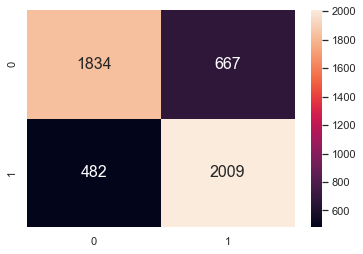

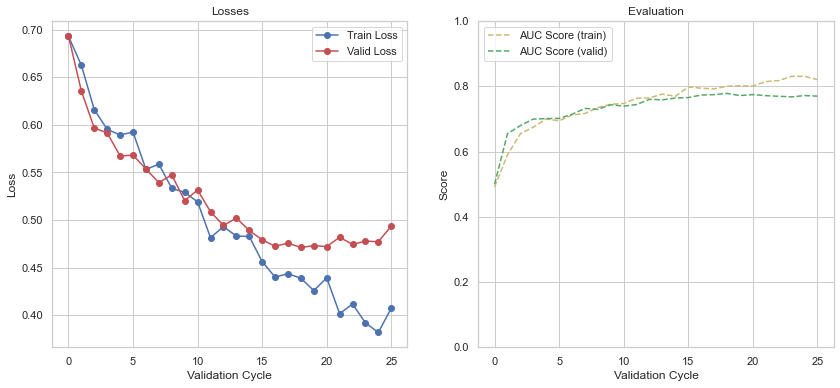

Epoch:  40%|█████████████████████████████████████████████████▌                                                                          | 4/10 [43:01<1:04:31, 645.29s/it]


,Accuracy,Auc(macro),Total_Time,ms/text
25000,0.7698,0.7699,2581.157203,103.246288


In [215]:
import config
import torch
from time import perf_counter
import warnings
warnings.filterwarnings("ignore")
def set_logger(file_name, TMPDIR):
    logging.basicConfig(level=logging.DEBUG)
    formatter_fh = logging.Formatter('%(asctime)-15s::%(module)s:%(funcName)s: %(levelname)-7s - %(message)s')
    formatter_ch = logging.Formatter('%(levelname)s::%(module)s::%(funcName)s: %(message)s')
    ch = logging.StreamHandler()
    ch.setLevel(logging.DEBUG)
    ch.setFormatter(formatter_ch)
    log = logging.getLogger(__name__)
    log.addHandler(ch)
    return log 

# Define the training parameters
# These parameters can be fine tuned to achieve better model performance.
num_samples = [25000]
epochs=10
patience=1 # normally patience is set to 3 but use patience = 1 for case study.
batch_size=64 # number of samples per gradient update
seq_len = 30 # sequence length for tokenized tensor
lr=3e-4 # learning rate for optimization algorithm
clip=5 # clip the gradient to prevent the exploading gradient
log_level=logging.DEBUG

# Run training cycles
result_lstm, model_trained_lstm = train_cycles(pd.Series(preprocessed), df_train['sentiment'], vocabulary, weights, 
                                               num_samples, epochs, patience, batch_size, seq_len, lr, clip, log_level)

# Save the model and show the result
output_dir = "C:/Users/zliu3/ds-take-home-challenge/"
torch.save(model_trained_lstm.state_dict(), output_dir + 'sentiments_lstm3.dict')
result_lstm

#### Summary

After training 5 epochs, our model performance (AUC score) stops improving so we early stopped after the fifth training epoch. Inspecting train loss vs validation loss and train AUC score vs validation AUC score over 5 epoches, the model starts overfitting to the training data from the fourth epoch (validation cycle = 15). Since we overfit from the fourth cycle, so three epochs will be the best.

In [313]:
# View LSTM model structure
model_trained_lstm.eval()

LstmTextClassifier(
  (embedding): Embedding(996, 200)
  (lstm): LSTM(200, 400, num_layers=4, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=400, out_features=1, bias=True)
  (activation): Sigmoid()
)

#### 7. Run Predictions

Make predictions on text reviews in test data set using our trained model and pre-trained vocabulary.

In [324]:
# Define a function to retun the prediction
import torch.nn.functional as F
def predict(text, model, batch_size = 50):
    """ 
    Make a prediction on a test data.
    Parameters
    ----------
        text : The texts to make a prediction on.
        model : The model to use for making the prediction.
    Returns
    -------
        y_pred : Prediction vector
    """   
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    preprocessed_text = [preprocess(reviews) for reviews in text]
    y_pred = []
    hidden = model.init_hidden(batch_size)
 
    X_test = torch.utils.data.DataLoader(preprocessed_text, batch_size, shuffle=False)
    for i, text_batch in enumerate(X_test):
        inputs = LstmTextClassifier.tokenizer_lstm(text_batch, vocabulary, seq_len = 30, 
                                                   padding='left').transpose(1,0).to(device)
        hidden = tuple([each.to(device) for each in hidden])
        outputs, hidden = model(inputs, hidden)
        y_pred.extend(outputs.cpu().detach().numpy())
    
    return y_pred

In [321]:
pred = []
pred = predict(df_test['review'], model_trained_lstm, batch_size = 50)

In [322]:
df = pd.DataFrame({'id':df_test['id'].to_numpy(), 'pred':np.reshape(pred, (15000))})
# Save predictions
df.to_csv('C:/Users/zliu3/ds-take-home-challenge/mysubmission.txt', index=None, sep='\t', mode='a')
df.head()

,id,pred
0,2,0.505246
1,5,0.805774
2,6,0.846566
3,12,0.089490
4,16,0.211734


#### 8. Error Analysis

We want to see some reviews that the LSTM model missclassified. There might be some semantic meaning loss in preprocessing steps. But the main challenge I see is the ambiguity caused by the inconsistency in the reviews. 

In the first example, the reviewer first claimed that the children loved the movie but later critiqued the movie was not subtle. Then again the reviewer said he/she would like to go watch the movie again with children. This ambiguity is creating some difficulty for us to classify the sentiment based on the trained vocabulary. It might be helpful to train a larger vocabulary list so that we can include word sequences that are rarer but useful to infer sentiments.

In [351]:
# Some error analysis
print('Truth Predicted Prob Sentiment')
y_hat = predict(df_train['review'][0:50], model_trained_lstm, batch_size = 50)
y_pred = [1 if pred >= 0.5 else 0 for pred in y_hat]
for x, y, z, m in zip(df_train['review'][0:20], df_train['sentiment'][0:20], y_pred, y_hat):
    if y != int(z):
        print('%d\t%d\t%0.2f\t%s' % (y, z, m, (preprocess(x))))

Truth Predicted Prob Sentiment
0	1	0.85	all in all this is movie for kids we saw it tonight and my child loved it at one point my kid's excitement was so great that sitting was impossible however am great fan of milne's books which are very subtle and hide wry intelligence behind the childlike quality of its leading characters this film was not subtle it seems shame that disney cannot see the benefit of making movies from more of the stories contained in those pages although perhaps it doesn't have the permission to use them found myself wishing the theater was replaying winnie the pooh and tigger too instead the characters voices were very good was only really bothered by kanga the music however was twice as loud in parts than the dialog and incongruous to the film as for the story it was bit preachy and militant in tone overall was disappointed but would go again just to see the same excitement on my child's face liked lumpy's laugh
1	0	0.46	another fantastic offering from the monkey

#### Computer System Infomation

System Model:	HP ZBook Studio G7 Mobile Workstation

Processor:	Intel(R) Core(TM) i7-10850H CPU @ 2.70GHz, 2712 Mhz, 6 Core(s), 12 Logical Processor(s)

Installed Physical Memory (RAM)	16.0 GB
